##Spiral classification

Generate a dataset of random 1000 points per class spread spirally in 2D space, train a model to classify the given dataset. Note that there is no unseen data here. We're only trying to fit a model in this notebook and visualize it.

In [1]:
!wget https://raw.githubusercontent.com/Atcold/pytorch-Deep-Learning/master/res/plot_lib.py

--2020-09-20 21:29:32--  https://raw.githubusercontent.com/Atcold/pytorch-Deep-Learning/master/res/plot_lib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4399 (4.3K) [text/plain]
Saving to: ‘plot_lib.py’

plot_lib.py         100%[===================>]   4.30K  --.-KB/s    in 0s      

2020-09-20 21:29:32 (66.0 MB/s) - ‘plot_lib.py’ saved [4399/4399]



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import random
import torch
from torch import nn, optim
import math
from IPython import display
from plot_lib import plot_data, plot_model, set_default

In [4]:
set_default()

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 5  # num_classes
H = 100  # num_hidden_units

In [21]:
X = torch.zeros(N*C, D).to(device)
y = torch.zeros(N*C, dtype = torch.long).to(device)
for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    # When c = 0 and t = 0: start of linspace
    # When c = 0 and t = 1: end of linpace
    # This inner_var is for the formula inside sin() and cos() like sin(inner_var) and cos(inner_Var)
    inner_var = torch.linspace(
        # When t = 0
        (2 * math.pi / C) * (c),
        # When t = 1
        (2 * math.pi / C) * (2 + c),
        N
    ) + torch.randn(N) * 0.2
    
    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor((
            math.sin(inner_var[index]), math.cos(inner_var[index])
        ))
        y[ix] = c
        index += 1

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (5000, 2)
y: (5000,)


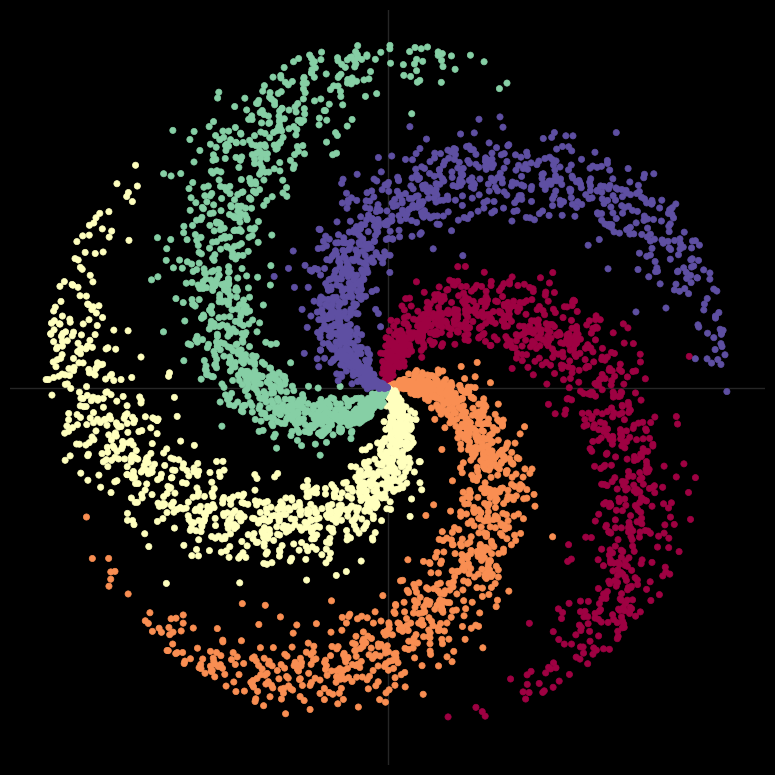

In [22]:
plot_data(X, y)

###Fitting a linear model for spiral classification

We can see that on a 2D space, this dataset is not linearly separable as it has multiple classes in any given axis(not separable by a linear plane)

In [23]:
learning_rate = 1e-3
lambda_l2 = 1e-5
model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)
model.to(device) #Convert to CUDA

# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Training
for t in range(1000):
    
    # push data to the model
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 999, [LOSS]: 1.252792, [ACCURACY]: 0.494


Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=5, bias=True)
)


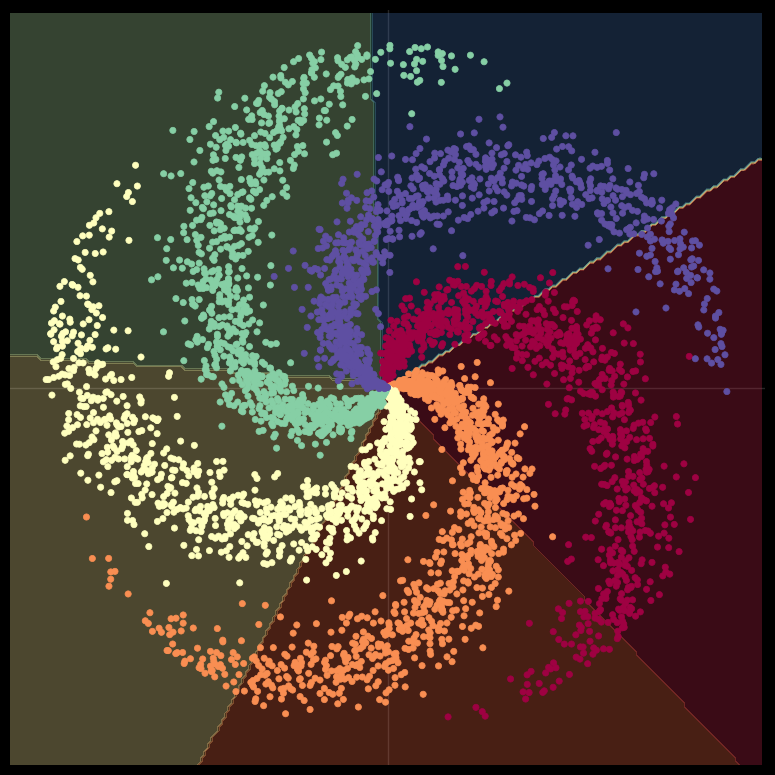

In [24]:
print(model)
plot_model(X, y, model)

###Classification with non-linearity in the model

Consider streching the datapoints to a hidden dimension of H. The non-linear function in the model projects the points in 2D space to the hidden dimension space \\
Being accustomed to TensorFlow, the concept of zero-grad is new, so explaining it briefly \\
PyTorch steps for training the model: \\
1. _Feed-forward network: Pushing the data to the model -_ We have parameters in model(for ex: x, ypred) and the intermediate function params which are fed to the model for a forward pass.
2. _Compute the loss_: Loss function(like _L1, L2_) that computes the difference(_absolute, euclidean_, depending on the function chosen)
3. _Zero-grad:_ It's because, for each of the params in PyTorch, it has two fields: _param.data and param.grad_ where the gradient of the parameter is also saved. _param.grad_ doesn't get erased as we progress for the next epoch. So we need to erase it and set it back to _zero_
4. _Accumulate the grad parameters_: This step computes the gradients of the parameters(backprop calculation)
5. _Optimization:_ It updates the parameters( in the opp direction of the computed gradient)

In [25]:
H = 256
# nn package to create our linear model
# each Linear module has a weight and bias

model = nn.Sequential(
    nn.Linear(D, H),
    nn.Tanh(),
    nn.Linear(H, C)
)
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 999, [LOSS]: 0.271651, [ACCURACY]: 0.911


Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): Tanh()
  (2): Linear(in_features=256, out_features=5, bias=True)
)


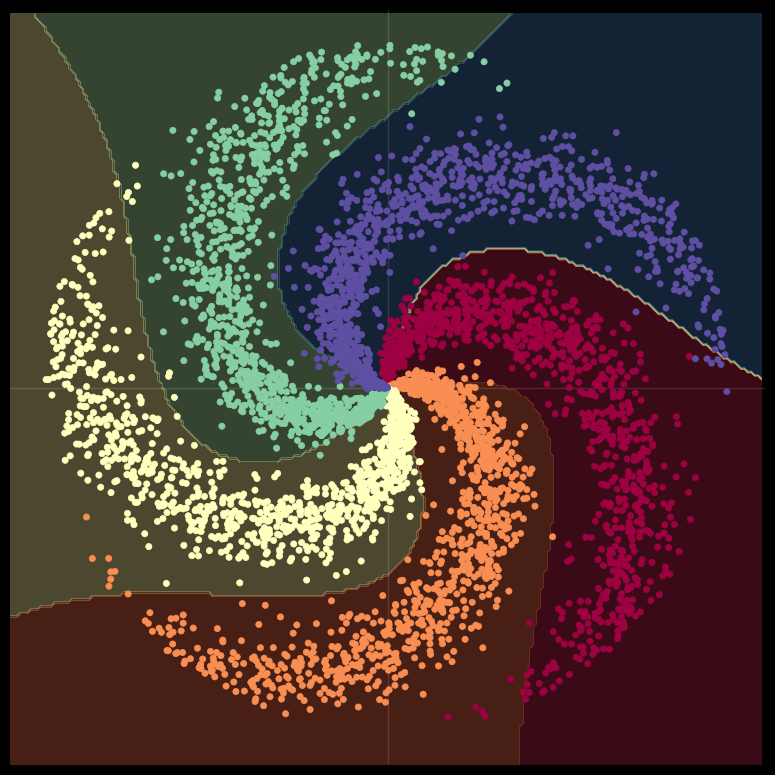

In [26]:
print(model)
plot_model(X,y, model)

The same 2-layer network using ReLU as the non-linearity function

In [32]:
H = 1000
# nn package to create our linear model
# each Linear module has a weight and bias

model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, C)
)
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 999, [LOSS]: 0.069282, [ACCURACY]: 0.995


Sequential(
  (0): Linear(in_features=2, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=5, bias=True)
)


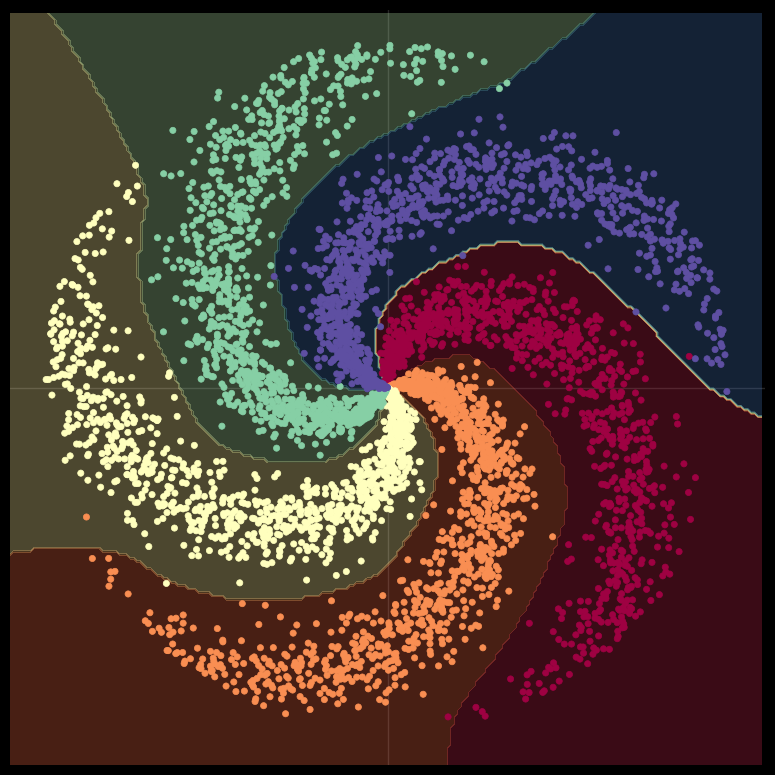

In [33]:
print(model)
plot_model(X, y, model)

Do you notice the difference? The sparse datapoints are also separated due to the _further stretching_ of the hidden dimension _H_ \\
Outliers are (almost) close to zero because of the better decision boundaries.

####An attempt to visually note the difference between smooth and edgy non-linearities  

Keeping the hidden dimensions small, we can visually understand how the two popular activation functions contribute in a multi-class classification \\

Consider _tanh()_ function, with _H = 4_

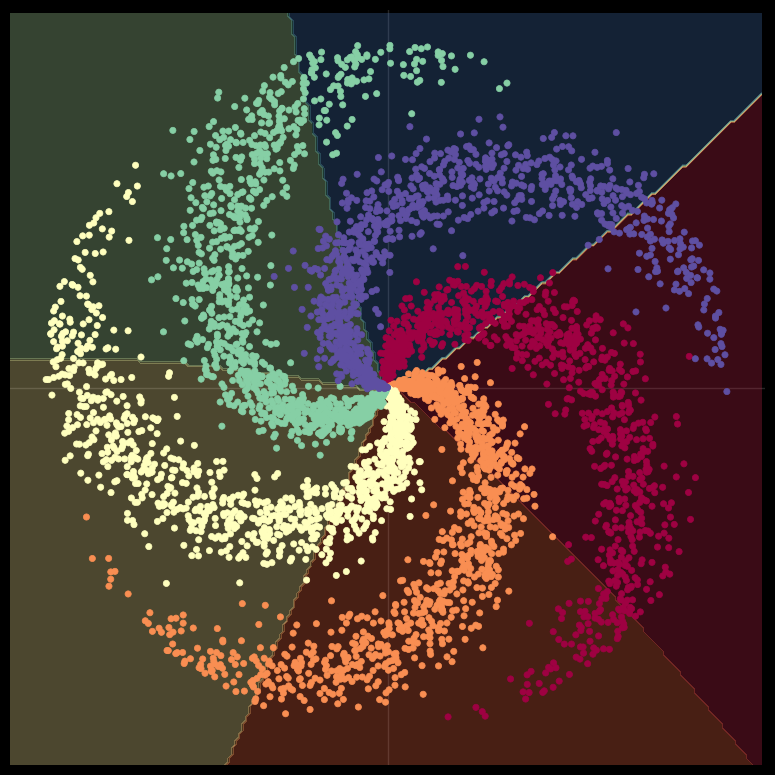

In [42]:
H = 4

model = nn.Sequential(
    nn.Linear(D, H),
    nn.Tanh(),
    nn.Linear(H, C)
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2


# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()


plot_model(X,y, model)

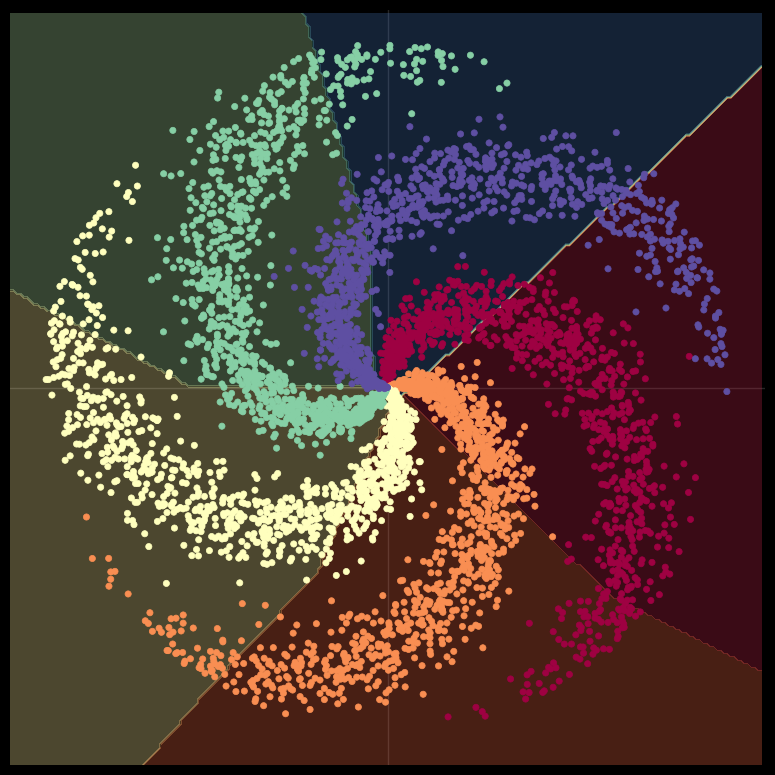

In [41]:
H = 4
# nn package to create our linear model
# each Linear module has a weight and bias

model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, C)
)
model.to(device)


criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()


plot_model(X, y, model)